# Exploration of Mus Musculus aging dynamics
On the [Tabula Muris Senis](https://github.com/czbiohub/tabula-muris-senis) dataset.  
Data is raw RNA-seq counts from
```
https://czb-tabula-muris-senis.s3-us-west-2.amazonaws.com/Data-objects/tabula-muris-senis-facs-official-raw-obj.h5ad
```

<!-- Gene annotations are from
```
ftp://ftp.ncbi.nih.gov/gene/DATA/GENE_INFO/Mammalia/Mus_musculus.gene_info.gz
``` -->

<br/>

**Pre-processed** as  
- RNA counts normalized to 1.0 per cell

<br/>

Cell **statistics** (expression mean and std.dev) are calculated - with 4 levels of granularity - on subsets defined by a unique combination of  
- Animal sex
- Tissue type
- Subtissue type
- Cell type

<br/>

Expression **fold-changes** computed between subsets of the pairs of age groups are filtered as  
- Subset has >= 3 cells
<!-- - Mean expression values are >= 4 max(std. dev) apart -->
- Expression is >= 1e-12 in both age groups
- Bonferroni correction is applied to p-values by multiplying them first by the number of genes (~20k) and then by the number of subsets (2-1000 depending on granularity). Results are then thresholded by 1e-5

<br/>

### Contents
- [Part I: Exploratory analysis of a single pair of age groups on a single dataset](#Part-I:-Exploratory-analysis-of-a-single-pair-of-age-groups-on-a-single-dataset)
- [Part II: Systematic sifting through a set of age groups on both FACS and Droplet datasets](#Part-II:-Systematic-sifting-through-a-set-of-age-groups-on-both-FACS-and-Droplet-datasets)

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

import gc
import numpy as np
import pandas as pd
import scanpy as sc

# Part I: Exploratory analysis of a single pair of age groups on a single dataset

In [2]:
# FACS - Raw
data = sc.read_h5ad('../data/tabula-muris/tabula-muris-senis-facs-official-raw-obj.h5ad')
# Droplet - Raw
# data = sc.read_h5ad('../data/tabula-muris/tabula-muris-senis-droplet-official-raw-obj.h5ad')

# def load_gene_info(path):
#   """Load the NCBI Gene file and returns a {gene_name: info} dictionary"""
#   gene_info = pd.read_csv(path, delimiter='\t')
#   gene_info_map = {}
#   for _, row in gene_info.iterrows():
#     info = {
#       'type': row['type_of_gene'],
#       'desc': row['Other_designations'].split('|')[0],
#     }
#     gene_info_map[row['Symbol']] = info
#     for s in row['Synonyms'].split('|'):
#       gene_info_map[s] = info
#   return gene_info, gene_info_map

# gene_info, gene_info_map = load_gene_info('../data/Mus_musculus.gene_info')
gene_names = data.var.index.values

In [3]:
data.obs.head()

,FACS.selection,age,cell,cell_ontology_class,cell_ontology_id,free_annotation,method,mouse.id,sex,subtissue,tissue,n_genes,n_counts
index,,,,,,,,,,,,,
A10_B000497_B009023_S10.mm10-plus-0-0,Multiple,18m,A10_B000497,bulge keratinocyte,nan,nan,facs,18_53_M,male,nan,Skin,2706,1009830.0
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,A10_B000756,pancreatic B cell,nan,pancreatic B cell,facs,18_45_M,male,Endocrine,Pancreas,3212,978772.0
A10_B000802_B009022_S10.mm10-plus-0-0,Multiple,18m,A10_B000802,bulge keratinocyte,nan,outer bulge,facs,18_47_F,female,Skin Anagen,Skin,2243,419722.0
A10_B000927_B007456_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,A10_B000927,skeletal muscle satellite cell,nan,nan,facs,18_46_F,female,Muscle Diaphragm,Limb_Muscle,2789,878950.0
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,nan,B cell,facs,18_46_F,female,RV,Heart,1237,6587.0


In [4]:
# data.var[:100]
# data.obs.query('age in ["3m", "18m", "24m"]')
data.obs.groupby(['age', 'sex']).agg(['count'])
# np.sort(data.X[:2].toarray().ravel())[::-1][:1000]

FACS.selection   cell cell_ontology_class cell_ontology_id  \
                    count  count               count            count   
age sex                                                                 
3m  female          19315  19315               19315            19315   
    male            25203  25203               25203            25203   
18m female          19163  19163               19163            19163   
    male            14864  14864               14864            14864   
21m female            728    728                 728              728   
24m male            31551  31551               31551            31551   

           free_annotation method mouse.id subtissue tissue n_genes n_counts  
                     count  count    count     count  count   count    count  
age sex                                                                       
3m  female           19315  19315    19315     19315  19315   19315    19315  
    male             25203  25203    25203     25203  25203   25203    25203  
18m female           19163  19163    19163     19163  19163   19163    19163  
    male             14864  14864    14864     14864  14864   14864    14864  
21m female             728    728      728       728    728     728      728  
24m male             31551  31551    31551     31551  31551   31551    31551

## Split by age
As seen in the table above, top age for males and females is different.  
To avoid mixing the age groups, the analysis is done only for **3m** and **24m males**.

In [5]:
# Split the data by age groups that will be compared
def split_by_age(data, age_groups):
  data_by_age = {}
  for age in age_groups:
    idxs = data.obs['age'] == age
    data_by_age[age] = {
      'data': data[idxs],
      'obs': data.obs[idxs],
    }
  return data_by_age

age_groups = ['3m', '24m']
data_by_age = split_by_age(data, age_groups)

In [6]:
# We'll compute statistics for each subset defined by a unique set these cell attributes
subset_names = [
  'sex',
  'tissue',
  'subtissue',
  'cell_ontology_class',
]

In [7]:
# Preview cell-counts in the subsets
data_grouped = data_by_age['3m']['obs'].groupby(subset_names)
data_grouped.agg(['count']).head(20)
# data_grouped.groups

FACS.selection  \
                                                                               count   
sex    tissue        subtissue   cell_ontology_class                                   
female Aorta         Heart       aortic endothelial cell                          60   
                                 epithelial cell                                   2   
                                 macrophage                                        8   
                                 professional antigen presenting cell             17   
       BAT           Fat         B cell                                          107   
                                 NK cell                                          12   
                                 T cell                                           26   
                                 endothelial cell                                 47   
                                 epithelial cell                                   2   
                                 mesenchymal stem cell of adipose                 25   
                                 myeloid cell                                     59   
       Bladder       nan         bladder cell                                    129   
                                 bladder urothelial cell                         199   
       Brain_Myeloid Cerebellum  macrophage                                       10   
                                 microglial cell                                 303   
                     Cortex      macrophage                                        1   
                                 microglial cell                                 459   
                     Hippocampus macrophage                                        1   
                                 microglial cell                                 560   
                     Striatum    macrophage                                        1   

                                                                        age  \
                                                                      count   
sex    tissue        subtissue   cell_ontology_class                          
female Aorta         Heart       aortic endothelial cell                 60   
                                 epithelial cell                          2   
                                 macrophage                               8   
                                 professional antigen presenting cell    17   
       BAT           Fat         B cell                                 107   
                                 NK cell                                 12   
                                 T cell                                  26   
                                 endothelial cell                        47   
                                 epithelial cell                          2   
                                 mesenchymal stem cell of adipose        25   
                                 myeloid cell                            59   
       Bladder       nan         bladder cell                           129   
                                 bladder urothelial cell                199   
       Brain_Myeloid Cerebellum  macrophage                              10   
                                 microglial cell                        303   
                     Cortex      macrophage                               1   
                                 microglial cell                        459   
                     Hippocampus macrophage                               1   
                                 microglial cell                        560   
                     Striatum    macrophage                               1   

                                                                       cell  \
                                                                      count   
sex    tissue        subtissue   cell_ontology_class                 

## Split into subsets
And calculate expression **mean** and **std. dev** for each one

In [8]:
def calc_subsets(age_group, subset_names):
  """Compute mean and std. dev for all the data subsets"""
  means = {}
  stds = {}
  sample_counts = {}
  i = 0
  obs_grouped = age_group['obs'].groupby(subset_names)
  for key, group in obs_grouped:
    if not isinstance(key, tuple):
      key = (key,)
    data_array = age_group['data'][group.index].X
    # AnnData.X is usually a sparse matrix, but sometimes is an array
    if not isinstance(data_array, np.ndarray):
      data_array = data_array.toarray()
    # Skip tiny subsets
    if len(data_array.shape) < 2 or data_array.shape[0] < 3:
      continue
    data_array = data_array / (np.sum(data_array, axis=1, keepdims=True) + 1e-8)
    means[key] = np.mean(data_array, axis=0)
    stds[key] = np.std(data_array, axis=0)
    sample_counts[key] = group.index.shape[0]
    # Subsetting from AnnData can be memory-heavy, so clean it up a bit
    # (maybe, those `toarray()` calls produce the garbage?)
    if i % 10 == 0:
      gc.collect()
    i += 1
  return means, stds, sample_counts


def calc_all_subsets(data_by_age):
  means = {}
  stds = {}
  sample_counts = {}
  for age, age_group in data_by_age.items():
    means[age], stds[age], sample_counts[age] = calc_subsets(age_group, subset_names)
  return means, stds, sample_counts


means, stds, sample_counts = calc_all_subsets(data_by_age)

C:\Users\ghost\Anaconda3\lib\site-packages\anndata\core\anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


## Compute fold-changes in expression

In [9]:
def calc_diffs(means, stds, sample_counts, start_age, end_age):
  """Compute expression differences between age groups"""
  diffs = {}
  confidences = {}
  for key in means[start_age].keys():
    if key not in means[end_age]:
      # No corresponding subset in the other age group - skip it     
      continue
    fold_diff = np.maximum(
      means[end_age][key] / (means[start_age][key] + 1e-12),
      means[start_age][key] / (means[end_age][key] + 1e-12)
    )
  #   avg_std = (stds[start_age][key] + stds[end_age][key]) / 2.0
    diffs[key] = fold_diff
    z_scores = np.abs(means[start_age][key] - means[end_age][key]) \
      / np.sqrt(
          np.power(stds[start_age][key] / np.sqrt(sample_counts[start_age][key]), 2) \
        + np.power(stds[end_age][key] / np.sqrt(sample_counts[end_age][key]), 2) \
      + 1e-12)
    p_values = 1.0 / np.sqrt(2.0 * np.pi) * np.exp(-0.5 * np.power(z_scores.astype(np.float64), 2))
    # Bonferroni correction
    p_values *= diffs[key].shape[0] * len(means)
    confidences[key] = p_values
    
#     # Debug
#     if key == ('male', 'Brain_Non-Myeloid', 'Striatum', 'oligodendrocyte'):
#       gene_idx = list(gene_names).index('Ppil2')
#       print(means[start_age][key][gene_idx])
#       print(means[end_age][key][gene_idx])
#       print(stds[start_age][key][gene_idx])
#       print(stds[end_age][key][gene_idx])
#       print(sample_counts[start_age][key])
#       print(sample_counts[end_age][key])
#       print(z_scores[gene_idx])
    
    # Ignore tiny expression amounts
    min_count = 1e-12
    diffs[key][(means[start_age][key] < min_count) | (means[end_age][key] < min_count)] = 0
    
    # Zero out results with > `max_p` confidence
    max_p = 1e-5
    diffs[key][confidences[key] > max_p] = 0
    
#     # Ignore differences less than `min_stds` std. deviations
#     min_stds = 4
#     abs_mean_diff = np.abs(means[end_age][key] - means[start_age][key])
#     max_std = np.maximum(stds[start_age][key], stds[end_age][key])
#     diffs[key][abs_mean_diff < max_std * min_stds] = 0
    
    # If sample count in both groups is >= `high_sample_count`
    # and mean difference is >= `high_stds` * max(std. dev)
    # set the measurement's confidence to 'high'
#     high_sample_count = 10
#     high_stds = 5

#     confidences[key] = np.array(['low' for _ in np.arange(diffs[key].shape[0])], dtype=object)
#     if sample_counts[start_age][key] >= high_sample_count \
#       and sample_counts[end_age][key] >= high_sample_count:
#       confidences[key][abs_mean_diff > max_std * high_stds] = 'high'
  return diffs, confidences


diffs, confidences = calc_diffs(means, stds, sample_counts, age_groups[0], age_groups[-1])

## Output the descending-ordered fold-changes

In [14]:
def build_results(diffs, confidences, means, stds, dataset_id, start_age, end_age, gene_names, subset_names):
  """Sort the resulting differences and arrange 'em into a DataFrame with metadata"""
  # Python 3 dicts are ordered, be cool
  diff_arr = np.stack(list(diffs.values()), axis=0)
  confidence_arr = np.stack(list(confidences.values()), axis=0)
  subset_labels = [
    k if isinstance(k, tuple) else (k,) 
    for k in list(diffs.keys())
  ]
  # Descending ordered indexes into _subset x gene_ expression difference array
  ordered_diff_idxs = np.unravel_index(
    np.argsort(np.abs(diff_arr), axis=None)[::-1], 
    diff_arr.shape
  )
  gene_paths = [
    subset_labels[i] + (gene_names[j],) 
    for i, j in zip(*ordered_diff_idxs)
  ]

  # print(md_table)

  results = pd.DataFrame(
    [
      (dataset_id, start_age, end_age) \
      + path \
      + (
#         gene_info_map.get(path[-1], { 'desc': '' })['desc'],
        val,
        means[start_age][subset_labels[idx_i]][idx_j],
        means[end_age][subset_labels[idx_i]][idx_j],
        max(
          stds[start_age][subset_labels[idx_i]][idx_j], 
          stds[end_age][subset_labels[idx_i]][idx_j]
        ),
        conf,
      )
      for path, val, conf, (idx_i, idx_j) in zip(
        gene_paths, 
        diff_arr[ordered_diff_idxs], 
        confidence_arr[ordered_diff_idxs], 
        zip(*ordered_diff_idxs)
      )
    ],
    columns=[
      'Dataset', 'Start age', 'End age',
    ] \
    + subset_names \
#       'Sex', 'Tissue', 'Subtissue', 'Cell type', 'Gene',  # 'Gene info',
    + [
      'Gene', 
      'dExpression', 
      'Expression at start age', 
      'Expression at end age', 
      'Max expression std. dev',  # '$\\Delta$Expression'
      'Confidence (p-value)', 
    ]
  )
  
  # Threshold the minimum fold-change
  results = results[results['dExpression'] > 2.0]
  
  return results


def results2markdown(results):
  """Format DataFrame as a markdown table for in-Jupyter output"""
  # Generate Markdown table of the results
  nl = '\n'
  md_table = \
f"""
{'| ' + ' | '.join(results.columns) + ' |'}
{'| ' + ' | '.join(['---' for _ in np.arange(len(results.columns))]) + ' |'}
{nl.join([
  '| ' + ' | '.join(['{0}'.format(v) for v in row.values]) + ' |' 
  for _, row in results.iterrows()
])}
"""
  return md_table


results = build_results(
  diffs, confidences, means, stds, 'facs', age_groups[0], age_groups[-1], gene_names, subset_names
)
md_table = results2markdown(results.iloc[:20])
display(Markdown(md_table))


| Dataset | Start age | End age | sex | Gene | dExpression | Expression at start age | Expression at end age | Max expression std. dev | Confidence (p-value) |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| facs | 24m | 30m | male | Krt6a | 1106723.5 | 0.0008356425096280873 | 7.540598701005763e-10 | 0.003994071390479803 | 0.0 |
| facs | 24m | 30m | male | Krt13 | 309831.9375 | 0.00047220918349921703 | 1.5230816607925135e-09 | 0.002261705230921507 | 0.0 |
| facs | 24m | 30m | male | Krt16 | 56177.8046875 | 0.0004440221528057009 | 7.902871246301402e-09 | 0.002754871966317296 | 6.609455679340917e-208 |
| facs | 24m | 30m | male | Reg4 | 49348.3125 | 6.510892380795497e-10 | 3.217950143152848e-05 | 0.0010381421307101846 | 1.4491491672295825e-07 |
| facs | 24m | 30m | male | Sprr1b | 40385.02734375 | 9.200860949931666e-05 | 2.2772850272190226e-09 | 0.0006060250452719629 | 1.7629421891008577e-167 |
| facs | 24m | 30m | male | Krt76 | 34986.76953125 | 6.861007568659261e-05 | 1.9600290279697674e-09 | 0.0011496132938191295 | 7.706264693083828e-25 |
| facs | 24m | 30m | male | Krt24 | 31769.654296875 | 0.00010669292532838881 | 3.3573281932319787e-09 | 0.0007243055733852088 | 4.53845087578971e-162 |
| facs | 24m | 30m | male | Krt4 | 28904.865234375 | 0.0012810253538191319 | 4.431767663959363e-08 | 0.00763982767239213 | 2.798121896172275e-226 |
| facs | 24m | 30m | male | Mt4 | 25489.482421875 | 0.0015013942029327154 | 5.8901502342223466e-08 | 0.005938917864114046 | 0.0 |
| facs | 24m | 30m | male | Krt35 | 23419.82421875 | 3.230738002457656e-05 | 1.3784885455336848e-09 | 0.0004568661388475448 | 3.67697847773925e-31 |
| facs | 24m | 30m | male | Phgr1 | 20659.546875 | 1.582160003010813e-08 | 0.00032688776263967156 | 0.002345218788832426 | 5.093753818494296e-229 |
| facs | 24m | 30m | male | Krt84 | 19163.37109375 | 0.00012170329137006775 | 6.349828662877144e-09 | 0.0016080125933513045 | 1.0928965017090382e-42 |
| facs | 24m | 30m | male | Krtap3-3 | 18377.455078125 | 3.85218663723208e-05 | 2.0951480550479573e-09 | 0.0004934764001518488 | 1.127628888419381e-39 |
| facs | 24m | 30m | male | Gm5485 | 17382.234375 | 1.3456328273875329e-09 | 2.3407486878568307e-05 | 0.00017011021554935724 | 8.482608449181419e-75 |
| facs | 24m | 30m | male | Gpr87 | 14916.7490234375 | 9.71620738710044e-06 | 6.503622640430251e-10 | 3.9209655369631946e-05 | 3.257778719802307e-16 |
| facs | 24m | 30m | male | Slc7a9 | 11781.333984375 | 7.658669254340111e-10 | 9.034714821609668e-06 | 5.766086542280391e-05 | 3.03934840067302e-13 |
| facs | 24m | 30m | male | Gm94 | 9190.4609375 | 0.0001552649773657322 | 1.6893144660912185e-08 | 0.0006111312541179359 | 0.0 |
| facs | 24m | 30m | male | Cnfn | 9046.369140625 | 0.00020298516028560698 | 2.2437301794298037e-08 | 0.0013218099484220147 | 2.9168318078362653e-185 |
| facs | 24m | 30m | male | Miox | 6730.00537109375 | 3.12205941099819e-08 | 0.00021012149227317423 | 0.0009753445046953857 | 0.0 |
| facs | 24m | 30m | male | Krt5 | 6534.9931640625 | 0.00027746628620661795 | 4.245754325893358e-08 | 0.0011264524655416608 | 0.0 |


# Part II: Systematic sifting through a set of age groups on both FACS and Droplet datasets

In [11]:
datasets = [
  {
    'id': 'facs',
    'path': '../data/tabula-muris/tabula-muris-senis-facs-official-raw-obj.h5ad',
    'age_groups': [ ('3m', '18m'), ('3m', '24m'), ('18m', '24m') ],
  },
  {
    'id': 'droplet',
    'path': '../data/tabula-muris/tabula-muris-senis-droplet-official-raw-obj.h5ad',
    'age_groups': [
      ('3m', '18m'), ('3m', '21m'), ('3m', '24m'), ('18m', '21m'), 
      ('3m', '30m'), ('21m', '24m'), ('24m', '30m'), 
    ],
  },
]

granularities = [
  [
    'sex',
    'tissue',
    'subtissue',
    'cell_ontology_class',
  ],
  [
    'sex',
    'tissue',
    'subtissue',
  ],
  [
    'sex',
    'tissue',
  ],
  [
    'sex',
  ],
]

all_results = {}
for granularity in granularities:
  granularity_results = {}
  for dataset in datasets:
    data = sc.read_h5ad(dataset['path'])
    gene_names = data.var.index.values
    for age_groups in dataset['age_groups']:
      data_by_age = split_by_age(data, age_groups)
#       subset_names = [
#         'sex',
#         'tissue',
#         'subtissue',
#         'cell_ontology_class',
#       ]
      subset_names = granularity
      # Get RNA count stats for all cell subsets defined by `subset_names`
      means, stds, sample_counts = calc_all_subsets(data_by_age)
      # Compute differences in mean expressions between age groups
      diffs, confidences = calc_diffs(means, stds, sample_counts, age_groups[0], age_groups[-1])
      if len(diffs) < 1:
        print(
          'age groups {0} in {1} dataset have no intersecting cell subsets at granularity {2}, no differences were computed' \
          .format(age_groups, dataset['id'], subset_names[-1])
        )
        continue
      results = build_results(
        diffs, confidences, means, stds, 
        dataset['id'], age_groups[0], age_groups[-1], gene_names, subset_names
      )
      results.to_csv(
        './results/{0}-{1}-{2}-{3}.csv'.format(
          dataset['id'], age_groups[0], age_groups[-1], subset_names[-1]
        )
      )
      granularity_results[(dataset['id'], age_groups[0], age_groups[-1])] = results
      all_results[(dataset['id'], age_groups[0], age_groups[-1], subset_names[-1])] = results
      
  merged_results = pd.concat(granularity_results.values()) \
    .sort_values(['dExpression'], ascending=[False])
  merged_results.to_csv('./results/merged-{0}.csv'.format(subset_names[-1]))

age groups ('3m', '30m') in droplet dataset have no intersecting cell subsets at granularity cell_ontology_class, no differences were computed
age groups ('21m', '24m') in droplet dataset have no intersecting cell subsets at granularity cell_ontology_class, no differences were computed
age groups ('24m', '30m') in droplet dataset have no intersecting cell subsets at granularity cell_ontology_class, no differences were computed
age groups ('3m', '30m') in droplet dataset have no intersecting cell subsets at granularity subtissue, no differences were computed
age groups ('21m', '24m') in droplet dataset have no intersecting cell subsets at granularity subtissue, no differences were computed
age groups ('24m', '30m') in droplet dataset have no intersecting cell subsets at granularity subtissue, no differences were computed
age groups ('21m', '24m') in droplet dataset have no intersecting cell subsets at granularity tissue, no differences were computed
age groups ('21m', '24m') in droplet 

In [22]:
merged_results = pd.concat(all_results.values(), sort=False) \
  .sort_values(['subtissue', 'cell_ontology_class'], na_position='first') \
  .drop_duplicates(
    subset=['Dataset', 'Start age', 'End age', 'sex', 'tissue', 'Gene', 'dExpression'],
    keep='first'
  ) \
  .sort_values(['dExpression'], ascending=[False])

merged_results.to_csv('./results/merged.csv')
# merged_results = merged_results[merged_results['dExpression'] > 2.0]
# merged_results.head(100)
# merged_grouped_results = merged_results.groupby([
#   'Sex', 'Tissue', 'Subtissue', 'Cell type', 'Gene'
# ])
# merged_grouped_results.head()

# merged_results.to_csv('./results/merged.csv')

md_table = results2markdown(merged_results.iloc[:100])
display(Markdown(md_table))


| Dataset | Start age | End age | sex | tissue | subtissue | cell_ontology_class | Gene | dExpression | Expression at start age | Expression at end age | Max expression std. dev | Confidence (p-value) |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| droplet | 3m | 30m | male | nan | nan | nan | Krt6a | 1887068.5 | 0.001424849615432322 | 7.540598701005763e-10 | 0.004652134142816067 | 0.0 |
| droplet | 24m | 30m | male | nan | nan | nan | Krt6a | 1106723.5 | 0.0008356425096280873 | 7.540598701005763e-10 | 0.003994071390479803 | 0.0 |
| droplet | 3m | 24m | male | Kidney | nan | nan | Slc12a1 | 470437.34375 | 0.0015329810557886958 | 3.257629499486825e-09 | 0.004109303466975689 | 3.82255978334385e-33 |
| facs | 18m | 24m | male | Diaphragm | Limb_Muscle | T cell | Mpo | 416463.0 | 0.018219418823719025 | 4.374699003051319e-08 | 0.009715273045003414 | 2.8978210082615906e-13 |
| droplet | 3m | 30m | male | nan | nan | nan | Reg1 | 389832.15625 | 1.8185323247266183e-09 | 0.0007093122112564743 | 0.0037372345104813576 | 0.0 |
| droplet | 3m | 18m | female | nan | nan | nan | Ins1 | 349190.09375 | 9.35636457199962e-09 | 0.003267499152570963 | 0.01764858327805996 | 4.4580543198993516e-159 |
| droplet | 3m | 30m | male | nan | nan | nan | Krt13 | 330590.6875 | 0.0005038472008891404 | 1.5230816607925135e-09 | 0.002112005138769746 | 5.9005115922572765e-266 |
| droplet | 24m | 30m | male | nan | nan | nan | Krt13 | 309831.9375 | 0.00047220918349921703 | 1.5230816607925135e-09 | 0.002261705230921507 | 0.0 |
| droplet | 3m | 21m | female | nan | nan | nan | Ins1 | 272385.8125 | 9.35636457199962e-09 | 0.0025488133542239666 | 0.01550618838518858 | 1.0812611391687321e-206 |
| droplet | 24m | 30m | male | Kidney | nan | nan | Akr1c21 | 240924.078125 | 7.104028476589974e-09 | 0.0017117724055424333 | 0.0020490786992013454 | 0.0 |
| facs | 3m | 18m | female | Liver | nan | nan | Cyp3a11 | 228949.125 | 0.004003104288130999 | 1.748368916310028e-08 | 0.003131460165604949 | 1.3563658113694863e-53 |
| droplet | 3m | 21m | female | nan | nan | nan | Clps | 226880.3125 | 8.298249865035245e-10 | 0.00018849782645702362 | 0.0027583243791013956 | 1.1060300141798306e-32 |
| facs | 18m | 24m | male | BAT | nan | nan | Krt8 | 220999.90625 | 1.8101212750920581e-09 | 0.00040025761700235307 | 0.0011992501094937325 | 5.797106124269085e-17 |
| facs | 18m | 24m | male | BAT | nan | nan | Wfdc2 | 187699.75 | 1.2183406505883454e-09 | 0.0002288699324708432 | 0.0008276984444819391 | 1.589307441645952e-10 |
| droplet | 24m | 30m | male | Kidney | nan | nan | Slc12a1 | 183093.421875 | 3.257629499486825e-09 | 0.0005966336466372013 | 0.002478283131495118 | 2.3606444618528014e-68 |
| facs | 3m | 24m | male | BAT | nan | nan | Spt1 | 162695.5 | 6.733756663379609e-09 | 0.0010957146296277642 | 0.0035212980583310127 | 2.722388209195923e-14 |
| facs | 3m | 18m | female | Liver | nan | nan | Cd7 | 162374.046875 | 4.369599349018927e-09 | 0.0007096719346009195 | 0.0021582881454378366 | 5.638141478540036e-09 |
| facs | 3m | 18m | female | Liver | nan | nan | C8b | 150191.09375 | 0.0002187495556427166 | 1.4554748517525695e-09 | 0.0003318955423310399 | 1.2542981939861734e-11 |
| droplet | 3m | 24m | male | nan | nan | nan | Acan | 149021.75 | 0.000247092975769192 | 1.6571001237863925e-09 | 0.0007695002132095397 | 0.0 |
| droplet | 3m | 24m | male | Kidney | nan | nan | Akr1c21 | 139535.359375 | 0.0009914026595652103 | 7.104028476589974e-09 | 0.0014598675770685077 | 7.969704766058269e-118 |
| facs | 18m | 24m | male | Heart | LA | nan | Cd79a | 135759.953125 | 2.999867021458158e-09 | 0.0004073975724168122 | 0.0016760412836447358 | 1.923443593787907e-09 |
| facs | 18m | 24m | male | BAT | nan | nan | Car6 | 123551.046875 | 1.2555376738276891e-09 | 0.00015524654008913785 | 0.0006300217937678099 | 1.2763947036067868e-07 |
| facs | 3m | 24m | male | BAT | nan | nan | Upk1a | 108589.046875 | 1.3503443918594371e-09 | 0.0001467411930207163 | 0.0006037256680428982 | 2.569375267702447e-07 |
| facs | 3m | 18m | female | Liver | nan | nan | Mug-ps1 | 101227.9140625 | 3.692524114740081e-05 | 3.6377331702475146e-10 | 6.279288936639205e-05 | 4.447299467401966e-08 |
| facs | 3m | 18m | female | Liver | nan | nan | Itgb7 | 92726.1953125 | 6.243642935999105e-09 | 0.0005790420109406114 | 0.0012782603735104203 | 3.3213411890142276e-20 |
| facs | 3m | 18m | female | Liver | nan | nan | Ltb | 92578.640625 | 8.32194757549587e-09 | 0.000770527170971036 | 0.0013362427707761526 | 6.176863622806161e-35 |
| droplet | 3m | 18m | female | nan | nan | nan | Ins2 | 91358.640625 | 1.3472934767833067e-07 | 0.012308781035244465 | 0.06671489030122757 | 5.891358233720039e-158 |
| droplet | 3m | 24m | male | Kidney | nan | nan | Timp3 | 84067.8671875 | 0.0014221890596672893 | 1.6916153811052936e-08 | 0.0014064733404666185 | 1.9069540292621392e-265 |
| droplet | 3m | 30m | male | nan | nan | nan | Krt16 | 82760.015625 | 0.0006541245384141803 | 7.902871246301402e-09 | 0.0033821172546595335 | 3.9016701951628322e-174 |
| facs | 3m | 18m | female | Liver | nan | nan | Gzmb | 73803.2890625 | 1.1417190748375106e-08 | 0.0008427000138908625 | 0.0028103836812078953 | 7.20626039797032e-07 |
| facs | 3m | 18m | female | Liver | nan | nan | Bcl2 | 68213.5546875 | 3.5350209426354695e-09 | 0.00024120455782394856 | 0.0006095667486079037 | 1.4701172235683227e-14 |
| droplet | 3m | 30m | male | nan | nan | nan | Sprr1b | 64779.390625 | 0.00014758591714780778 | 2.2772850272190226e-09 | 0.000805809919256717 | 6.778993054850206e-151 |
| droplet | 3m | 24m | male | nan | nan | nan | Bpifa1 | 62748.015625 | 0.0007812401163391769 | 1.244943526046427e-08 | 0.007634931709617376 | 2.5946510365804102e-46 |
| droplet | 24m | 30m | male | Kidney | nan | nan | Timp3 | 62536.21875 | 1.6916153811052936e-08 | 0.0010579348308965564 | 0.001245922758243978 | 0.0 |
| droplet | 3m | 30m | male | nan | nan | nan | Cela2a | 61482.23828125 | 6.525306872617875e-08 | 0.004011966288089752 | 0.02051854319870472 | 0.0 |
| facs | 18m | 24m | male | SCAT | nan | nan | Pnlip | 59851.140625 | 2.1346846512670936e-09 | 0.00012782316480297595 | 0.0005989376804791391 | 2.4036029309993837e-06 |
| droplet | 3m | 21m | female | nan | nan | nan | Ins2 | 59818.98828125 | 1.3472934767833067e-07 | 0.008059432730078697 | 0.048406943678855896 | 3.597866130834103e-212 |
| facs | 3m | 24m | male | Liver | Hepatocytes | nan | Gm11428 | 56541.4375 | 6.501313709605938e-09 | 0.0003676501801237464 | 0.0008898014202713966 | 1.4009067660347243e-06 |
| droplet | 24m | 30m | male | nan | nan | nan | Krt16 | 56177.8046875 | 0.0004440221528057009 | 7.902871246301402e-09 | 0.002754871966317296 | 6.609455679340917e-208 |
| facs | 18m | 24m | male | SCAT | nan | nan | Bpifa2 | 54155.8125 | 9.655168220490395e-09 | 0.0005229376256465912 | 0.002381042344495654 | 5.890417360940024e-07 |
| droplet | 3m | 30m | male | nan | nan | nan | Krt24 | 51197.78125 | 0.0001719389547361061 | 3.3573281932319787e-09 | 0.0008327234536409378 | 3.9776988992883226e-193 |
| droplet | 24m | 30m | male | Kidney | nan | nan | Spink3 | 50673.33203125 | 7.925944345288372e-08 | 0.00401639100164175 | 0.004533448256552219 | 0.0 |
| facs | 3m | 18m | female | Liver | nan | nan | H2-Oa | 50555.9765625 | 2.9265192491578773e-09 | 0.0001480036007706076 | 0.0004500212089624256 | 5.9931674919056075e-09 |
| droplet | 3m | 18m | male | nan | nan | nan | Otor | 49606.66015625 | 8.954067743616179e-05 | 1.8040132720997804e-09 | 0.0009266487904824317 | 7.79834136535557e-40 |
| droplet | 24m | 30m | male | nan | nan | nan | Reg4 | 49348.3125 | 6.510892380795497e-10 | 3.217950143152848e-05 | 0.0010381421307101846 | 1.4491491672295825e-07 |
| facs | 3m | 18m | female | Liver | nan | nan | Gimap7 | 49346.5078125 | 4.321927260519942e-09 | 0.00021332137112040073 | 0.0004652552306652069 | 9.825238401932697e-21 |
| droplet | 24m | 30m | male | Kidney | nan | nan | Calml4 | 46941.3984375 | 9.33637522848585e-09 | 0.00043830944923684 | 0.0005079015390947461 | 0.0 |
| droplet | 3m | 30m | male | nan | nan | nan | Krt76 | 45888.171875 | 8.998803969006985e-05 | 1.9600290279697674e-09 | 0.0013476306339725852 | 1.7644134545921768e-17 |
| facs | 18m | 24m | male | BAT | nan | nan | Serpina3k | 45203.078125 | 2.5699495864728306e-09 | 0.0001162148400908336 | 0.0005148763302713633 | 8.16500282506412e-06 |
| facs | 3m | 18m | female | Liver | nan | nan | Gpr18 | 44379.58203125 | 5.390813573313835e-09 | 0.00023928642622195184 | 0.0006294572958722711 | 3.635107019059941e-13 |
| facs | 3m | 18m | female | Liver | nan | nan | Epsti1 | 43726.734375 | 2.6395756691499628e-09 | 0.00011546375753823668 | 0.0002778440248221159 | 2.587775571213705e-16 |
| facs | 3m | 24m | male | Liver | Hepatocytes | nan | Vsig4 | 43536.7890625 | 2.2805055621688552e-08 | 0.0009929024381563067 | 0.0021960290614515543 | 1.3983886345776335e-08 |
| facs | 18m | 24m | male | BAT | nan | nan | Cyp3a11 | 43374.1640625 | 1.5688114141099163e-09 | 6.808925536461174e-05 | 0.0003015478723682463 | 9.15650897137691e-06 |
| droplet | 3m | 30m | male | nan | nan | nan | Krt35 | 43340.62890625 | 5.9787900681840256e-05 | 1.3784885455336848e-09 | 0.0006195657188072801 | 1.983344831525696e-38 |
| droplet | 3m | 24m | male | nan | nan | nan | Col10a1 | 43158.94921875 | 0.00013596405915450305 | 3.149309701910852e-09 | 0.0011989612830802798 | 8.840318541315366e-57 |
| facs | 3m | 18m | female | Liver | nan | nan | Cytip | 42636.6171875 | 2.5020585603385825e-09 | 0.0001067219563992694 | 0.0002847565629053861 | 1.2968911294809515e-12 |
| droplet | 3m | 18m | male | nan | nan | nan | Ins2 | 41821.375 | 3.4747114341371343e-07 | 0.014531763270497322 | 0.07472457736730576 | 8.764949204679453e-184 |
| droplet | 24m | 30m | male | nan | nan | nan | Sprr1b | 40385.02734375 | 9.200860949931666e-05 | 2.2772850272190226e-09 | 0.0006060250452719629 | 1.7629421891008577e-167 |
| facs | 18m | 24m | male | BAT | nan | nan | Ldhc | 39399.81640625 | 3.7216283388374904e-09 | 0.00014667087816633284 | 0.0005216369754634798 | 5.636462638236408e-11 |
| facs | 3m | 18m | female | Liver | nan | nan | Mug2 | 38084.05078125 | 0.00023767168750055134 | 6.239714522848772e-09 | 0.00026413906016387045 | 1.0574008308530658e-24 |
| droplet | 24m | 30m | male | Kidney | nan | nan | Hnf4a | 38043.6640625 | 4.094030003898297e-09 | 0.00015578995225951076 | 0.00022968155099079013 | 0.0 |
| facs | 3m | 18m | female | Liver | nan | nan | Faim3 | 36122.01953125 | 1.3583413505102726e-08 | 0.0004906964604742825 | 0.0014992880169302225 | 7.39712056172973e-09 |
| droplet | 3m | 24m | male | nan | nan | nan | Sftpc | 35859.03515625 | 0.0005013013142161071 | 1.397877724684804e-08 | 0.010098690167069435 | 3.061772708965985e-08 |
| droplet | 24m | 30m | male | nan | nan | nan | Krt76 | 34986.76953125 | 6.861007568659261e-05 | 1.9600290279697674e-09 | 0.0011496132938191295 | 7.706264693083828e-25 |
| droplet | 3m | 24m | male | Kidney | nan | nan | Hnf4a | 34296.94921875 | 0.00014044703857507557 | 4.094030003898297e-09 | 0.00025845630443654954 | 7.582661511603972e-73 |
| facs | 3m | 18m | female | Liver | nan | nan | Map4k1 | 34021.73828125 | 3.7320861956402496e-09 | 0.00012700608931481838 | 0.0003932522376999259 | 1.70981692634392e-08 |
| droplet | 3m | 30m | male | nan | nan | nan | Col2a1 | 33889.3515625 | 0.0006920801242813468 | 2.042075841757196e-08 | 0.002711151260882616 | 1.352097492857714e-305 |
| facs | 3m | 18m | female | Liver | nan | nan | Ly9 | 32521.580078125 | 3.1643150322224756e-09 | 0.00010294104868080467 | 0.00033694496960379183 | 3.2453199075171286e-07 |
| droplet | 24m | 30m | male | nan | nan | nan | Krt24 | 31769.654296875 | 0.00010669292532838881 | 3.3573281932319787e-09 | 0.0007243055733852088 | 4.53845087578971e-162 |
| facs | 3m | 18m | female | Liver | nan | nan | Napsa | 31369.609375 | 9.29010735006841e-09 | 0.00029145841835998 | 0.0006998045137152076 | 1.6216104920806243e-16 |
| droplet | 3m | 24m | male | Kidney | nan | nan | Spink3 | 31220.78125 | 0.0024745729751884937 | 7.925944345288372e-08 | 0.0036662656348198652 | 2.1238898003625066e-116 |
| facs | 3m | 18m | female | Liver | nan | nan | H2-DMb2 | 30273.099609375 | 2.0022261182361945e-08 | 0.000606166198849678 | 0.0014720053877681494 | 4.390376186452859e-16 |
| facs | 18m | 24m | male | BAT | Fat | myeloid cell | Ldhc | 30081.47265625 | 1.0573597997165507e-08 | 0.0003180994826834649 | 0.000731860229279846 | 1.7215763612974926e-12 |
| droplet | 3m | 24m | male | Kidney | nan | nan | Calml4 | 30013.716796875 | 0.0002802493399940431 | 9.33637522848585e-09 | 0.0003948401426896453 | 4.4647651493665767e-128 |
| facs | 3m | 18m | female | Liver | nan | nan | Ncf4 | 30007.25 | 4.366481398676569e-09 | 0.0001310561056016013 | 0.00029209087369963527 | 1.2853229001718183e-19 |
| facs | 3m | 18m | female | Liver | nan | nan | Ctsw | 29967.59765625 | 1.2717961794805888e-08 | 0.0003811567439697683 | 0.0009542901534587145 | 6.471038893091117e-15 |
| droplet | 3m | 30m | male | nan | nan | nan | Mt4 | 29821.873046875 | 0.0017565828748047352 | 5.8901502342223466e-08 | 0.005649079568684101 | 0.0 |
| droplet | 24m | 30m | male | nan | nan | nan | Krt4 | 28904.865234375 | 0.0012810253538191319 | 4.431767663959363e-08 | 0.00763982767239213 | 2.798121896172275e-226 |
| droplet | 24m | 30m | male | Kidney | nan | nan | Aldob | 27899.75390625 | 9.322714333848126e-08 | 0.00260104238986969 | 0.002803180366754532 | 0.0 |
| facs | 3m | 18m | female | Liver | nan | nan | Il2rb | 27310.142578125 | 1.0355513779813919e-08 | 0.00028283786377869546 | 0.0009231164585798979 | 2.5425326725069516e-07 |
| facs | 3m | 18m | female | Liver | nan | nan | Nkg7 | 26804.4453125 | 3.76863340534328e-08 | 0.0010101880179718137 | 0.002343457890674472 | 5.756067056144295e-18 |
| facs | 3m | 18m | female | Liver | nan | nan | Cd79b | 26206.16015625 | 3.478822563351969e-08 | 0.0009116919827647507 | 0.002330661052837968 | 3.5981272982768633e-14 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Ppil2 | 26086.26171875 | 9.562943159835413e-05 | 3.664892389565466e-09 | 0.00017788528930395842 | 2.0255371939722143e-15 |
| facs | 3m | 18m | female | Liver | nan | nan | Ms4a4b | 25633.208984375 | 1.8090052122943234e-08 | 0.00046373173245228827 | 0.0011971311178058386 | 8.008747700184536e-14 |
| droplet | 24m | 30m | male | nan | nan | nan | Mt4 | 25489.482421875 | 0.0015013942029327154 | 5.8901502342223466e-08 | 0.005938917864114046 | 0.0 |
| droplet | 3m | 30m | male | nan | nan | nan | Krtap3-3 | 24850.34765625 | 5.209001028561033e-05 | 2.0951480550479573e-09 | 0.0005630051018670201 | 1.30896846649585e-34 |
| droplet | 3m | 18m | female | nan | nan | nan | Sst | 24263.505859375 | 1.865071119766526e-08 | 0.00045255591976456344 | 0.007631553336977959 | 3.4318839994188547e-13 |
| facs | 3m | 18m | female | Liver | nan | nan | Gimap3 | 24131.10546875 | 2.4720883118334314e-08 | 0.0005965663585811853 | 0.0012602368369698524 | 2.1796109155692484e-22 |
| droplet | 3m | 18m | male | Kidney | nan | lymphocyte | S100a8 | 23938.904296875 | 3.248440862080315e-06 | 0.07776413857936859 | 0.07736752927303314 | 2.2933287382995585e-08 |
| facs | 3m | 24m | male | Liver | Hepatocytes | nan | Cybb | 23917.193359375 | 6.759796722377587e-09 | 0.00016169928130693734 | 0.00036829643067903817 | 7.240672015713914e-08 |
| facs | 3m | 18m | female | Liver | nan | nan | Pik3cd | 23785.82421875 | 2.4443147506048035e-09 | 5.816382690682076e-05 | 0.0001805665815481916 | 2.8055650772211477e-08 |
| facs | 18m | 24m | male | BAT | nan | nan | Mal | 23677.962890625 | 3.459501352054417e-09 | 8.193762187147513e-05 | 0.0003025854821316898 | 7.680034329262816e-10 |
| facs | 3m | 24m | male | Brain_Non-Myeloid | Striatum | oligodendrocyte | Aldh6a1 | 23548.62109375 | 8.632671233499423e-05 | 3.664892389565466e-09 | 0.00015953877300489694 | 1.2669133046215906e-15 |
| droplet | 3m | 24m | male | nan | nan | nan | 3110079O15Rik | 23443.986328125 | 0.0006273901090025902 | 2.6760238469591968e-08 | 0.0018081284360960126 | 0.0 |
| droplet | 24m | 30m | male | nan | nan | nan | Krt35 | 23419.82421875 | 3.230738002457656e-05 | 1.3784885455336848e-09 | 0.0004568661388475448 | 3.67697847773925e-31 |
| facs | 3m | 18m | female | Liver | nan | nan | Ms4a1 | 23353.470703125 | 1.586522202501328e-08 | 0.0003705313429236412 | 0.0010961487423628569 | 1.1094842261891415e-09 |
| droplet | 3m | 18m | female | nan | nan | nan | Gcg | 23237.8046875 | 8.049083533023804e-08 | 0.0018704535905271769 | 0.021522652357816696 | 2.4571826322150386e-32 |
| facs | 3m | 24m | male | Aorta | Heart | aortic endothelial cell | Igfbp5 | 23192.078125 | 0.0008412777679041028 | 3.62733594272413e-08 | 0.0012657494517043233 | 7.773174176474623e-09 |
| droplet | 3m | 21m | female | nan | nan | nan | Sst | 22813.181640625 | 1.865071119766526e-08 | 0.00042550486978143454 | 0.007862471044063568 | 2.723753018750103e-19 |
| facs | 3m | 18m | male | Aorta | Heart | aortic endothelial cell | Igfbp5 | 22762.837890625 | 0.0008412777679041028 | 3.6957388260816515e-08 | 0.0012657494517043233 | 7.773537900607733e-09 |


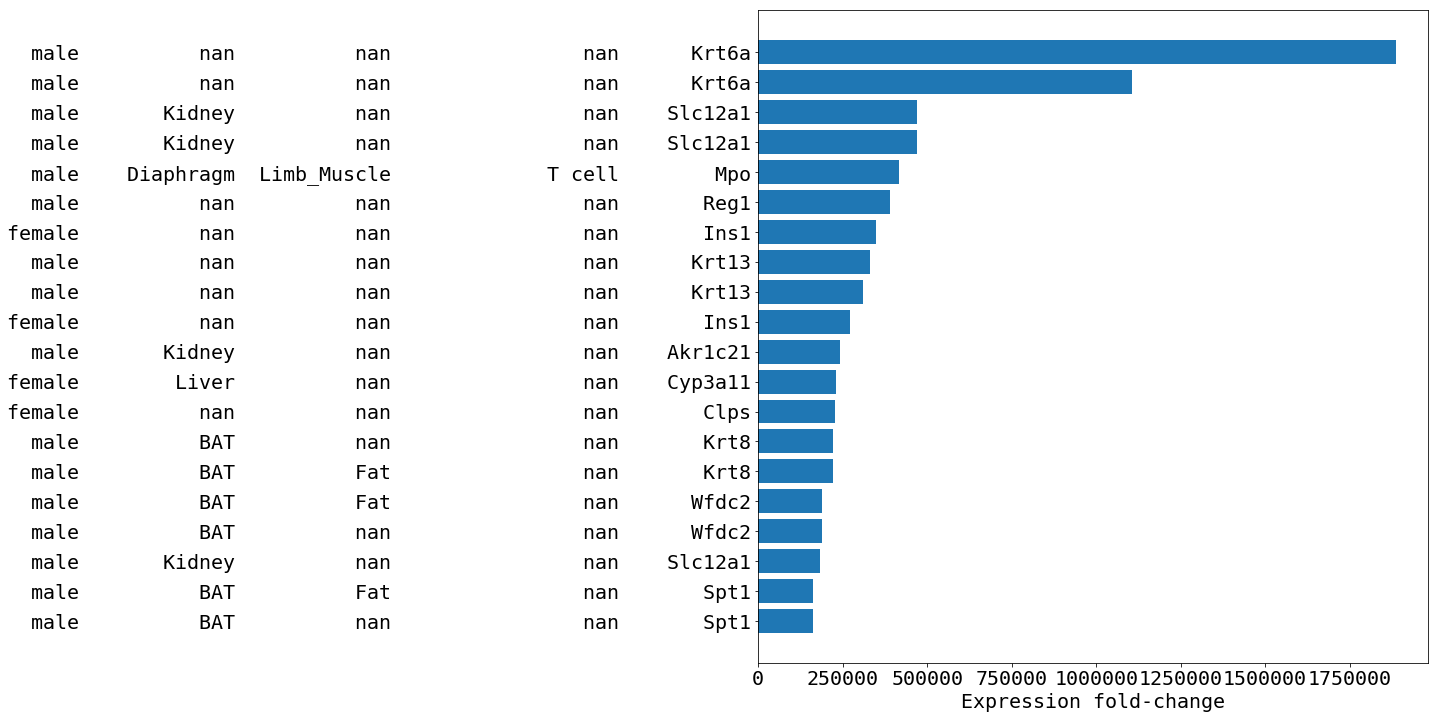

In [13]:
font = {'family' : 'monospace',
        'weight' : 'regular',
        'size'   : 20}

matplotlib.rc('font', **font)

n_plot = 20
fig, ax = plt.subplots(figsize=(12, 12))
ax.barh(np.arange(n_plot), merged_results["dExpression"][:n_plot])
ax.invert_yaxis()
ax.set_xlabel('Expression fold-change')
ax.set_yticks(np.arange(n_plot))
_ = ax.set_yticklabels([
  '{0} {1} {2} {3} {4}'.format(
    row['sex'], 
    str(row['tissue']).rjust(12), 
    str(row['subtissue']).rjust(12), 
    str(row['cell_ontology_class'])[:15].rjust(18), 
    row['Gene'].rjust(10)
  )
  for _, row in merged_results.iloc[:n_plot].iterrows()
])